In [43]:
import pandas as pd

# Load the dataset
loan_data = pd.read_csv('Credit_Data.csv')

# Display the first few rows to inspect the dataset
loan_data.head()


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [42]:
# Check for any missing values in the dataset
missing_values = loan_data.isnull().sum()
missing_values


customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

In [41]:
from sklearn.model_selection import train_test_split

# Define the predictor variables and target variable
X = loan_data.drop(columns=['customer_id', 'default'])
y = loan_data['default']

# Split the dataset into training (80%) and testing (20%) subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)



In [40]:
from sklearn.preprocessing import StandardScaler

# Initialize the standard scaler
scaler = StandardScaler()

# Scale the training data
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test data using the same transformation
X_test_scaled = scaler.transform(X_test)



In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Train a logistic regression model on the scaled training data
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_scaled, y_train)

# Predict on the test set and evaluate accuracy and AUC
y_pred = logistic_model.predict(X_test_scaled)
y_pred_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)



In [37]:
from sklearn.ensemble import RandomForestClassifier

# Train a random forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set and evaluate accuracy and AUC
y_rf_pred = rf_model.predict(X_test_scaled)
y_rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
rf_accuracy = accuracy_score(y_test, y_rf_pred)
rf_auc = roc_auc_score(y_test, y_rf_pred_proba)



In [34]:
def calculate_expected_loss(loan_data_sample, recovery_rate=0.1):
    """
    Calculate expected loss using Logistic Regression and Random Forest models.

    Parameters:
    - loan_data_sample (pd.DataFrame/pd.Series): Data for the loan.
    - recovery_rate (float): Assumed recovery rate on default.

    Returns:
    - tuple: Expected loss from both models.
    """
    if isinstance(loan_data_sample, pd.Series):
        loan_data_sample = loan_data_sample.to_frame().transpose()

    loan_data_scaled = scaler.transform(loan_data_sample)
    pd_lr = logistic_model.predict_proba(loan_data_scaled)[:, 1][0]
    pd_rf = rf_model.predict_proba(loan_data_scaled)[:, 1][0]

    loss_given_default = 1 - recovery_rate
    expected_loss_lr = loan_data_sample['loan_amt_outstanding'].values[0] * pd_lr * loss_given_default
    expected_loss_rf = loan_data_sample['loan_amt_outstanding'].values[0] * pd_rf * loss_given_default

    return expected_loss_lr, expected_loss_rf

# Testing the function
sample_loan = X_test.iloc[0]
calculate_expected_loss(sample_loan)



(0.0001363101457265484, 0.0)

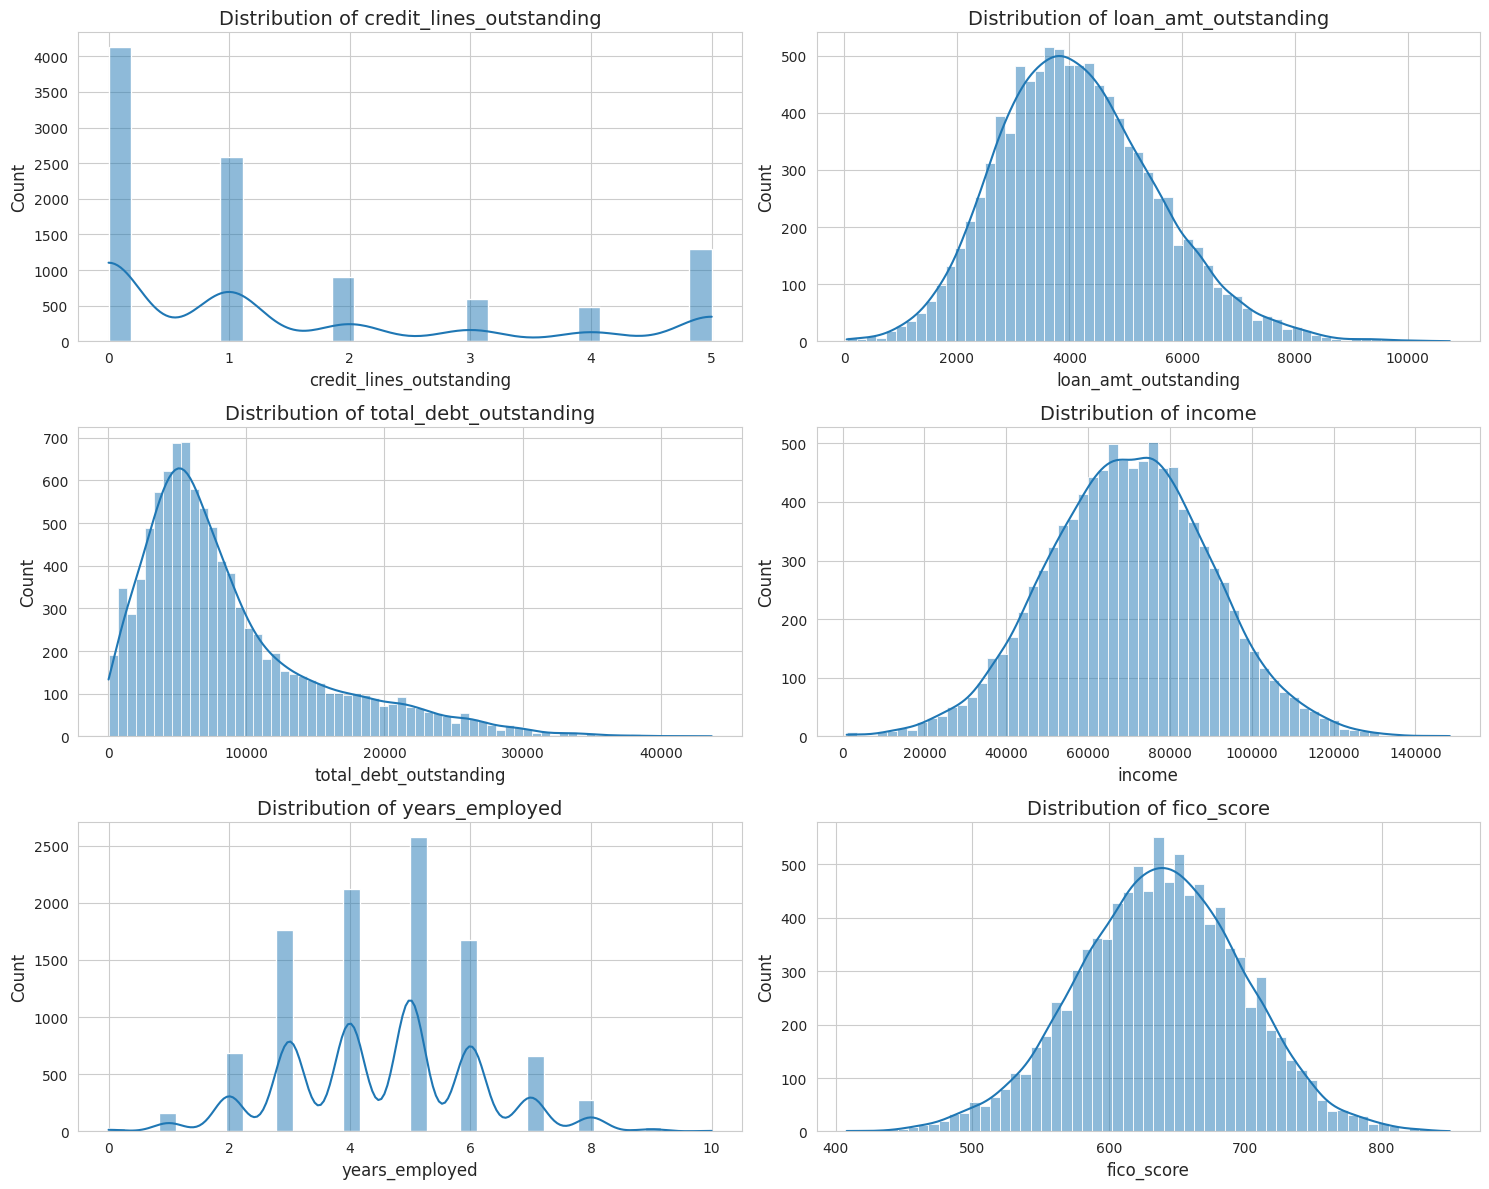

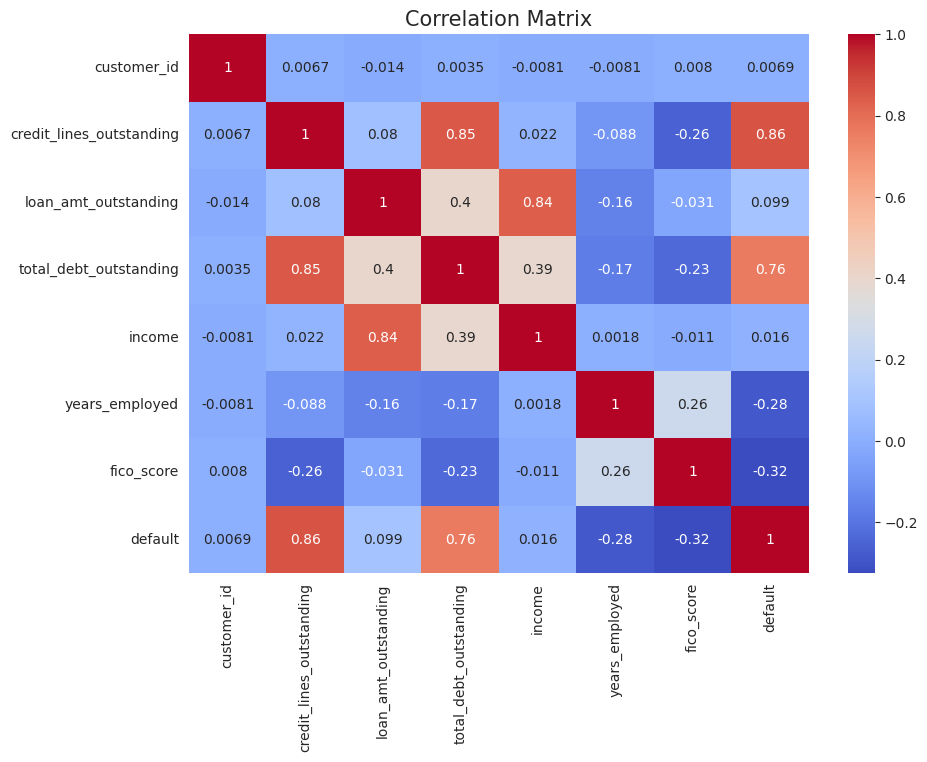

In [33]:
# Summary statistics
summary_statistics = loan_data.describe()

# Visualizing distributions of key features
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
features = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']

fig, ax = plt.subplots(3, 2, figsize=(15, 12))

for i, feature in enumerate(features):
    sns.histplot(loan_data[feature], ax=ax[i//2, i%2], kde=True)
    ax[i//2, i%2].set_title(f'Distribution of {feature}', fontsize=14)
    ax[i//2, i%2].set_xlabel(feature, fontsize=12)
    ax[i//2, i%2].set_ylabel('Count', fontsize=12)

plt.tight_layout()

# Correlation heatmap
correlation_matrix = loan_data.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=15)
plt.show()



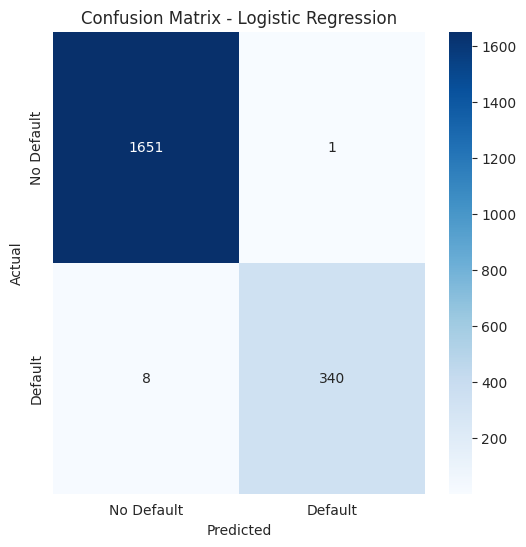

In [32]:
# Confusion matrix visualization
cm_logistic = confusion_matrix(y_test, logistic_model.predict(X_test_scaled))
plt.figure(figsize=(6, 6))
sns.heatmap(cm_logistic, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()




In [31]:
# Generate and print the classification report
report_logistic = classification_report(y_test, logistic_model.predict(X_test_scaled))
print("Classification Report - Logistic Regression:\n", report_logistic)



Classification Report - Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       1.00      0.98      0.99       348

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



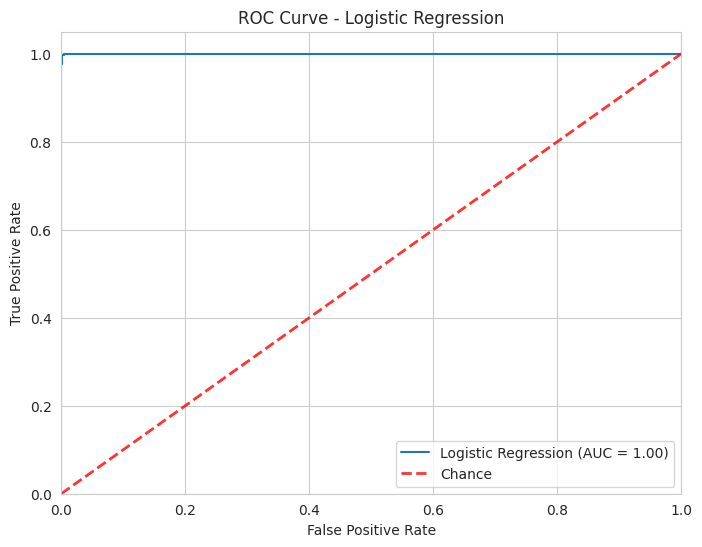

In [30]:
# ROC curve visualization
fpr, tpr, thresholds = roc_curve(y_test, logistic_model.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


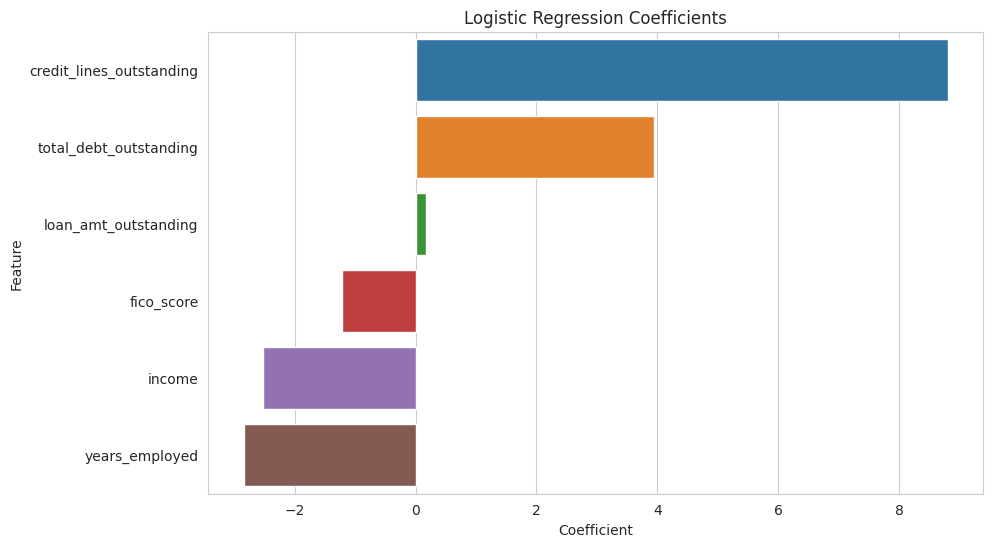

In [29]:
# Extracting and visualizing the coefficients from the logistic regression model
coefficients = logistic_model.coef_[0]
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coeff_df.sort_values(by="Coefficient", ascending=False))
plt.title('Logistic Regression Coefficients')
plt.show()




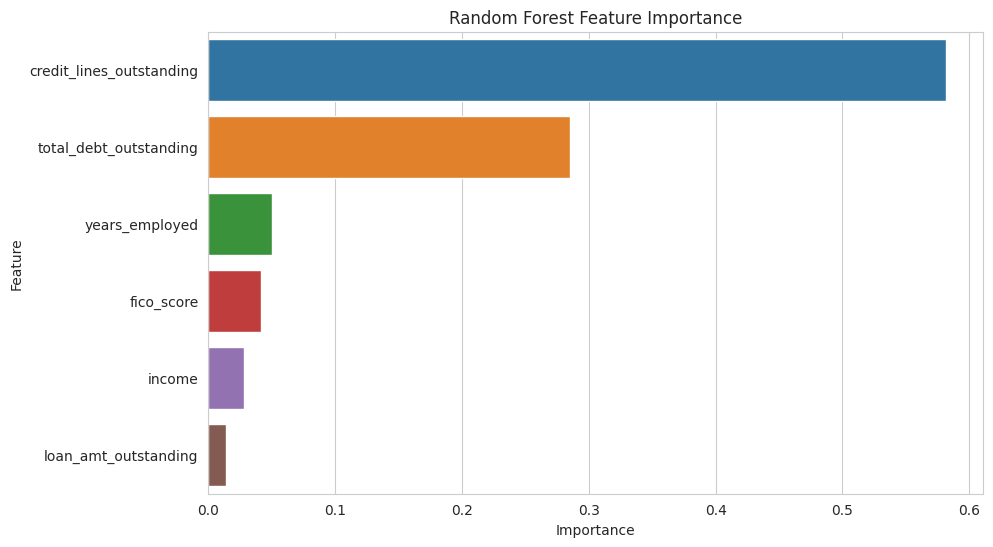

In [27]:
# Extracting and visualizing the feature importances from the random forest model
importance = rf_model.feature_importances_
feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df.sort_values(by="Importance", ascending=False))
plt.title('Random Forest Feature Importance')
plt.show()
